## Day2 Kisckstarter Project

## Day1からの変更

- 使用する説明変数を吟味<br>
  backers, pledged, usd pledged, usd_pledged_realはプロジェクト開始前にはわからないパラメータの為使用しない<br>
- 標準化、正規化の導入
- グリッドサーチによるハイパーパラメータの選定
- SVMの検討(計算時間の関係で断念)


In [20]:
#day1時点のデータ(Day2講義でして気の合った項目は削除)
#尤度、正答率、クロス集計表
y_est = clf.predict(X)
print("対数尤度=\t{}".format(log_loss(y,y_est)))
print("正答率=\t\t{:.3f}".format(accuracy_score(y,y_est)*100))


precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
print("Precision =\t{:.6}%".format(precision[1]*100))
print("Recall =\t{:.6}%".format(recall[1]*100))
print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))

conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed(success以外)', '正解 = success'], 
                        columns=['予測 = failed(success以外)', '予測 = success'])
conf_mat


対数尤度=	16.676972427195302
正答率=		51.716
Precision =	40.7784%
Recall =	80.6728%
F1値 =		54.1733%


,予測 = failed(success以外),予測 = success
正解 = failed(success以外),87763,156942
正解 = success,25890,108066


## データの解説
- 参照データ https://www.kaggle.com/kemical/kickstarter-projects<br>
ks-projects-201801.csv<br>
**クラウドファンディングが成功するか(state)を予測するのが目的**


- ID:ID
- name:プロジェクト名, アルバムや本、映画など
- category:詳細なカテゴリ
- main_category：大まかなカテゴリ
- currency：使用された通貨
- deadline：締め切り日時
- goal：目標支援額
- launched：開始した日時
- pledged：支援額
- state：プロジェクトの状態(成功、失敗、キャンセル)
- backers：支援者数
- country：プロジェクトが開かれた国
- usd pledged：集まった資金(米ドル)
- usd_pledged_real:支援額(US)
- usd_goal_real:目標支援額(US)



In [1]:
#ライブラリインポート
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from IPython.display import display
from datetime import datetime as dt
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import os

pd.set_option('display.max_columns', 50)

In [2]:
#関数定義
def object2time(time):
    return dt.strptime(time, '%Y-%m-%d')

def object2timeHMS(time):
    return dt.strptime(time, '%Y-%m-%d %H:%M:%S')


In [3]:
#データの読み込み

origin_data = pd.read_csv("./ks-projects-201801.csv",sep = ",")
origin_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
origin_data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [5]:
#データの確認
print(origin_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


In [6]:
#欠損値の確認
print(origin_data.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


In [7]:
origin_data.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [8]:
#ユニーク要素とユニーク件数
for column in origin_data.columns:
    print(column,origin_data[column].dtype)
    print(origin_data[column].unique())
print("unique件数")
print(origin_data.nunique())

ID int64
[1000002330 1000003930 1000004038 ...  999986353  999987933  999988282]
name object
['The Songs of Adelaide & Abullah'
 'Greeting From Earth: ZGAC Arts Capsule For ET' 'Where is Hank?' ...
 'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!'
 'BioDefense Education Kit' 'Nou Renmen Ayiti!  We Love Haiti!']
category object
['Poetry' 'Narrative Film' 'Music' 'Film & Video' 'Restaurants' 'Food'
 'Drinks' 'Product Design' 'Documentary' 'Nonfiction' 'Indie Rock'
 'Crafts' 'Games' 'Tabletop Games' 'Design' 'Comic Books' 'Art Books'
 'Fashion' 'Childrenswear' 'Theater' 'Comics' 'DIY' 'Webseries'
 'Animation' 'Food Trucks' 'Public Art' 'Illustration' 'Photography' 'Pop'
 'People' 'Art' 'Family' 'Fiction' 'Accessories' 'Rock' 'Hardware'
 'Software' 'Weaving' 'Gadgets' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals'
 'Video Games' 'Anthologies' 'Publishing' 'Shorts' 'Electronic Music'
 'Radio & Podcasts' 'Apps' 'Cookbooks' 'Apparel' 'Metal' 'Comedy'
 'Hip-Hop' 'Periodicals

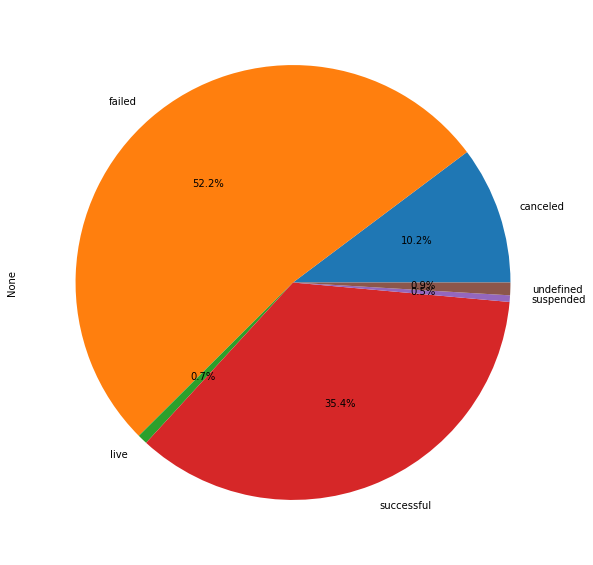

In [11]:
#stateの比率確認 failが50%越え
plt.figure(figsize= (10,10))
origin_data.groupby("state").size().plot(kind = "pie", autopct = "%1.1f%%")

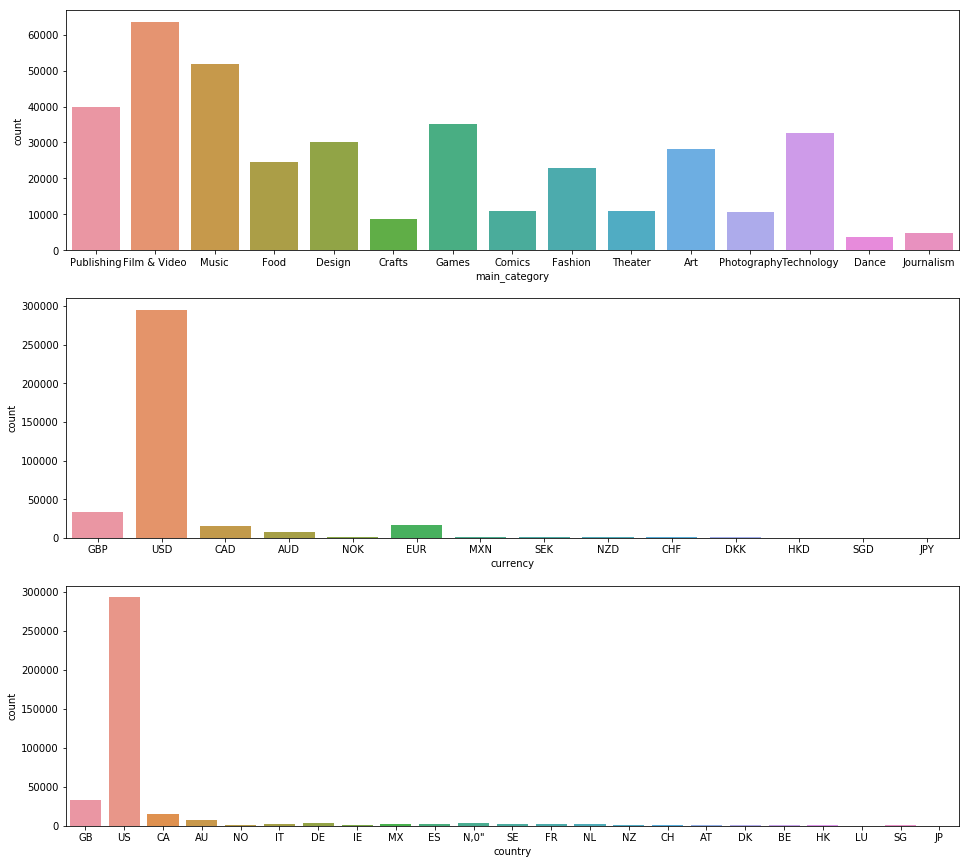

In [12]:
#データ分布確認
fig_n = 3
fig, ax = plt.subplots(fig_n,1,figsize=(16,fig_n*5))

sns.countplot(origin_data.main_category,ax=ax[0])
sns.countplot(origin_data.currency,ax=ax[1])
sns.countplot(origin_data.country,ax=ax[2])

plt.show()

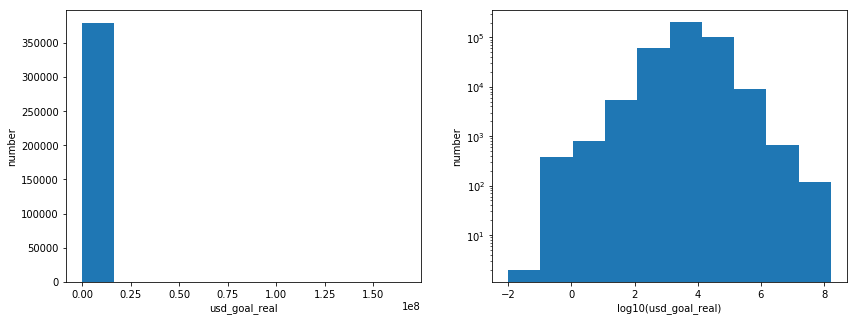

In [42]:

fig,ax = plt.subplots(1,2,figsize = (14,5))
ax[0].hist(origin_data["usd_goal_real"])
ax[0].set_xlabel('usd_goal_real')
ax[0].set_ylabel('number')
ax[1].hist(np.log10(origin_data["usd_goal_real"]),log=True)
ax[1].set_xlabel('log10(usd_goal_real)')
ax[1].set_ylabel('number')

plt.show()

# 方針/雑感
- state → 予測対象、まずはsuccessとその他に1/0で分ける
- ID → 不要と判断
- name → 不要と判断、欠損は無視
- category → ユニーク数が多いので保留
- main_category → ユニーク数がそこまで多くないのでワンホットエンコーディングかカテゴリごとにIDを振る
- currency  → ユニーク数がそこまで多くないのでワンホットエンコーディングかカテゴリごとにIDを振る
- deadline  → データ数の割にユニーク数が少ない、同じ値で比較するとで何か見えるかも
- goal → 同上→結果となるパラメータの為不採用
- launched → deadlineとの差分で期間が出るのでそちらを使う
- pledged → 現在の支援額、大きく影響すると思われる→結果となるパラメータの為不採用
- backers → データ数の割にユニーク数が少ない、Stateとの比較を実施→結果となるパラメータの為不採用
- country → データ数の割にユニーク数が少ない、同じ値で比較すると何か見えるかも、N,0"はNull?現状保留
- usd pledged → 欠損は0で埋める、Stateとの対比は実施→結果となるパラメータの為不採用
- usd_pledged_real → とりあえず予測に入れてみる→結果となるパラメータの為不採用
- usd_goal_real → とりあえず予測に入れてみる→予測対象として採用

In [9]:
#データコピー
df = origin_data.copy()

#stateの0/1変換
df.loc[df["state"] == "successful", "state"] = 1
df.loc[df["state"] != 1, "state"] = 0
df.drop("ID", axis=1, inplace=True)
df.drop("name", axis=1, inplace=True)
df.drop("category", axis=1, inplace=True)

#日付の型変更,priod(期間)の追加
df["deadline"] = df["deadline"].apply(object2time)
df["launched"] = df["launched"].apply(object2timeHMS)
df["period"] =  df["deadline"] - df["launched"]
df["period"] = df["period"].dt.days

df.drop("deadline", axis=1, inplace=True)
df.drop("launched", axis=1, inplace=True)


df.head()


,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,Publishing,GBP,1000.0,0.0,0,0,GB,0.0,0.0,1533.95,58
1,Film & Video,USD,30000.0,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,Film & Video,USD,45000.0,220.0,0,3,US,220.0,220.0,45000.00,44
3,Music,USD,5000.0,1.0,0,1,US,1.0,1.0,5000.00,29
4,Film & Video,USD,19500.0,1283.0,0,14,US,1283.0,1283.0,19500.00,55


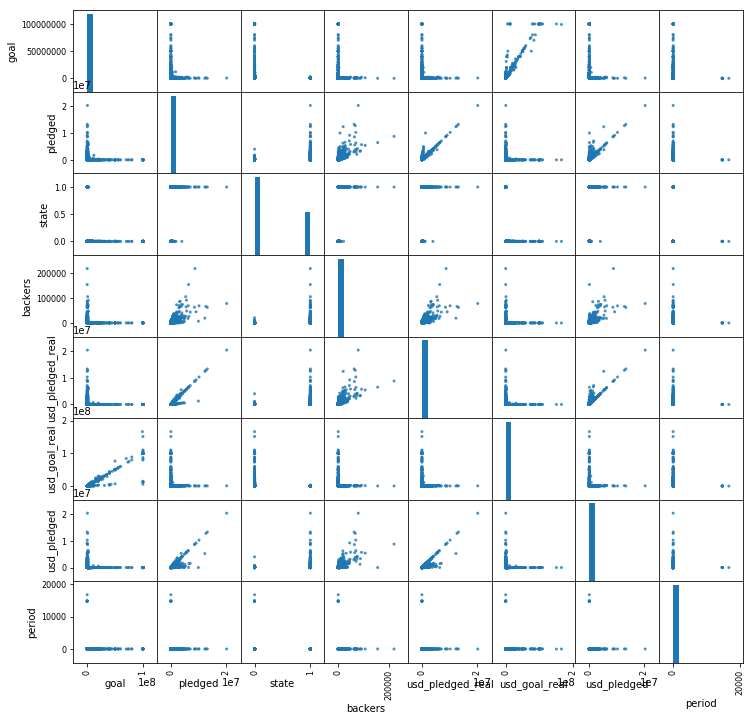

In [30]:
# 散布図
pd.plotting.scatter_matrix(df,alpha = 0.8, figsize=(12,12),range_padding = 0.5)
plt.show()

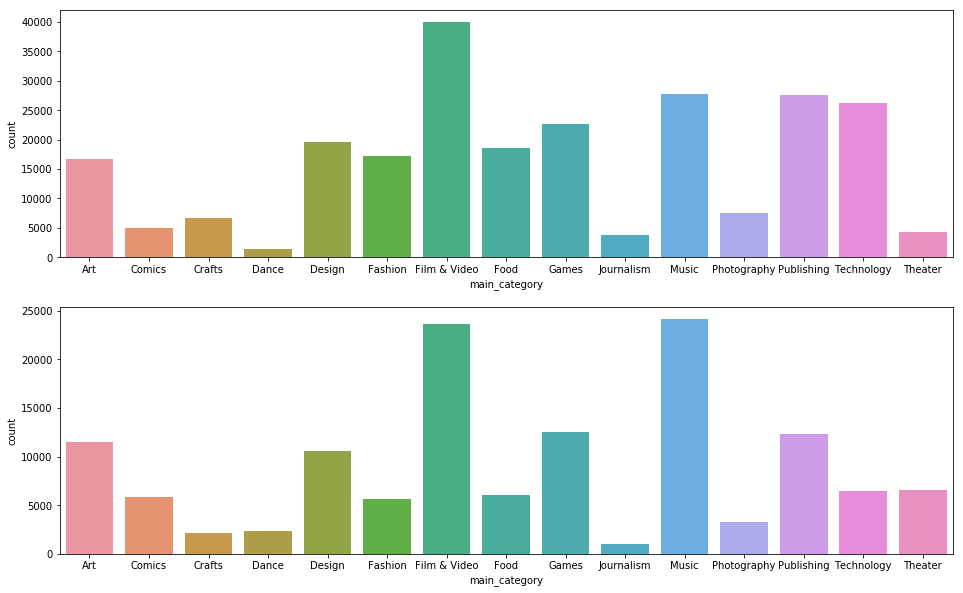

In [14]:
main_category = df["main_category"].value_counts()
main_category_failed = df[df["state"] == 0]["main_category"]
main_category_success = df[df["state"] == 1]["main_category"]
main_category_failed_counts = df[df["state"] == 0]["main_category"].value_counts()
main_category_success_counts = df[df["state"] == 1]["main_category"].value_counts()
fig_n = 2
fig, ax = plt.subplots(fig_n,1,figsize=(16,fig_n*5))
main_category_failed = main_category_failed.sort_values()
main_category_success = main_category_success.sort_values()
main_category_success_ratio = main_category_success_counts/(main_category_failed_counts+main_category_failed_counts)
sns.countplot(main_category_failed,ax=ax[0])
sns.countplot(main_category_success,ax=ax[1])


In [16]:
#レシオもグラフにしたかったが断念、次回何かを参考に作る
main_category_success_ratio

Art             0.345791
Comics          0.586900
Crafts          0.157977
Dance           0.817483
Design          0.270236
Fashion         0.162370
Film & Video    0.295568
Food            0.164308
Games           0.275569
Journalism      0.135186
Music           0.436438
Photography     0.221100
Publishing      0.223036
Technology      0.123092
Theater         0.746061
Name: main_category, dtype: float64

In [136]:
#データクレンジング
df = origin_data.copy()

#stateの0/1変換
df.loc[df["state"] == "successful", "state"] = 1
df.loc[df["state"] != 1, "state"] = 0

#不要なcolumnの削除
df.drop("ID", axis=1, inplace=True)
df.drop("name", axis=1, inplace=True)
df.drop("category", axis=1, inplace=True)
df.drop("goal", axis=1, inplace=True)
df.drop("pledged", axis=1, inplace=True)
df.drop("usd pledged", axis=1, inplace=True)
df.drop("usd_pledged_real", axis=1, inplace=True)
df.drop("backers", axis=1, inplace=True)
df.drop("country", axis=1, inplace=True)#currencyと相関があるため削除

#usd_goal_realの対数化
df["usd_goal_real"] = np.log10(df["usd_goal_real"])

#日付の型変更,priod(期間)の追加
df["deadline"] = df["deadline"].apply(object2time)
df["launched"] = df["launched"].apply(object2timeHMS)
df["period"] =  df["deadline"] - df["launched"]
df["period"] = df["period"].dt.days

df.drop("deadline", axis=1, inplace=True)
df.drop("launched", axis=1, inplace=True)


#ユニーク数が少ない項目をワンホットエンコーディング
df = pd.get_dummies(df,columns=["main_category"])
df = pd.get_dummies(df,columns=["currency"])
# df = pd.get_dummies(df,columns=["country"])

df.head()


,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,3.185811,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,4.477121,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,4.653213,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,3.698970,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,4.290035,55,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [105]:
#外れ値の確認
origin_data.iloc[df[df["period"] == df["period"].max()].index]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,0.0,suspended,0,CH,0.0,0.0,1905.97


In [116]:
print((origin_data["state"] =="suspended").value_counts())
origin_data[origin_data["state"] =="suspended"]

False    376815
True       1846
Name: state, dtype: int64


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
374,1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,USD,2014-08-09,25000.0,2014-06-30 21:17:10,39693.00,suspended,647,US,39693.00,39693.00,25000.00
688,1003367610,Aleppo - Make Soap Not War,Crafts,Crafts,DKK,2017-07-13,55000.0,2017-06-19 08:34:15,20320.00,suspended,60,DK,3059.73,3119.10,8442.45
689,1003378025,Hackchain - The World's First Wearable Wifi Ja...,Wearables,Technology,USD,2017-11-10,30000.0,2017-10-11 03:53:25,994.00,suspended,15,US,557.00,994.00,30000.00
1047,100524873,PRESIDENT OF THE UNITED STATES (Suspended),Academic,Publishing,USD,2015-10-25,5500.0,2015-08-26 05:54:42,0.00,suspended,0,US,0.00,0.00,5500.00
1114,1005618996,Masters of the Tooniverse Podcast (Suspended),Webseries,Film & Video,USD,2013-07-02,3200.0,2013-05-30 19:24:22,3226.00,suspended,24,US,3226.00,3226.00,3200.00
1187,1006032032,Buddy day in Heidepark Soltau (Suspended),People,Photography,EUR,2015-06-11,200.0,2015-05-12 11:06:35,13.00,suspended,3,DE,14.51,14.59,224.40
1570,10080310,parasuicidal tendancies a performance of rebir...,Art,Art,USD,2010-11-16,1000.0,2010-10-17 18:56:48,0.00,suspended,0,US,0.00,0.00,1000.00
1962,1010227672,Book of Guidance: The Adventure of Struggle,Poetry,Publishing,USD,2017-06-27,1000.0,2017-05-28 20:18:19,5.00,suspended,2,US,0.00,5.00,1000.00
2335,1012101826,Niko makes really good spaghetti (Suspended),Small Batch,Food,USD,2015-06-07,1100.0,2015-04-08 06:03:35,2.00,suspended,2,US,2.00,2.00,1100.00
2545,1013109821,I don't like names (Suspended),Nonfiction,Publishing,USD,2014-08-20,11.0,2014-07-21 16:29:20,0.00,suspended,0,US,0.00,0.00,11.00


In [11]:
df.describe()

,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,378661.000000,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.00000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,0.353762,4.545440e+04,33.481122,0.074349,0.028572,0.023264,0.009951,0.079411,0.060254,0.167921,0.064971,0.093041,0.012557,0.137109,0.028466,0.105303,0.086011,0.02882,0.020995,0.039513,0.002028,0.002982,0.045965,0.090139,0.001632,0.000106,0.004627,0.001907,0.003895,0.004722,0.001466,0.780025
std,0.478137,1.152950e+06,65.909172,0.262338,0.166600,0.150740,0.099257,0.270380,0.237958,0.373796,0.246475,0.290490,0.111354,0.343963,0.166300,0.306943,0.280381,0.16730,0.143368,0.194812,0.044990,0.054522,0.209409,0.286381,0.040366,0.010277,0.067863,0.043624,0.062291,0.068554,0.038256,0.414230
min,0.000000,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000e+03,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,5.500000e+03,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.550000e+04,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.663614e+08,16738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# 相関係数
df.corr()

,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
state,1.000000,-0.023052,-0.026096,0.032645,0.066792,-0.036689,0.055926,-0.001790,-0.057528,0.016683,-0.058673,0.001038,-0.033240,0.093623,-0.016879,-0.032497,-0.100224,0.088260,-0.030875,-0.032775,-0.010397,-0.003789,-0.060011,0.000123,-0.000359,-0.003843,-0.018214,-0.011701,-0.006544,-0.009952,-0.002648,0.065202
usd_goal_real,-0.023052,1.000000,0.004184,-0.001538,-0.003850,-0.004688,-0.003119,-0.000913,-0.005061,0.014483,0.000820,-0.000147,0.003966,-0.010401,-0.004927,-0.006146,0.015122,-0.002744,0.001511,-0.000282,0.008735,-0.000491,0.005604,-0.000875,-0.000757,-0.000257,-0.001809,0.000787,-0.001100,-0.000305,-0.000996,-0.002902
period,-0.026096,0.004184,1.000000,-0.005782,-0.000844,-0.006770,-0.002098,0.002233,-0.006241,0.008640,-0.001610,-0.009367,0.000162,0.007358,-0.001627,-0.000369,0.004566,0.001258,-0.002087,-0.000654,0.015683,-0.001044,0.001552,-0.011503,-0.000047,-0.000442,0.002560,0.000266,-0.002500,-0.001081,-0.001180,0.006864
main_category_Art,0.032645,-0.001538,-0.005782,1.000000,-0.048604,-0.043738,-0.028413,-0.083238,-0.071763,-0.127316,-0.074707,-0.090773,-0.031960,-0.112972,-0.048512,-0.097229,-0.086940,-0.048821,-0.011661,-0.002346,-0.002036,0.000934,-0.010145,0.004546,-0.002980,-0.000954,0.004412,-0.004541,-0.003016,-0.003074,-0.002964,0.008529
main_category_Comics,0.066792,-0.003850,-0.000844,-0.048604,1.000000,-0.026467,-0.017194,-0.050370,-0.043426,-0.077043,-0.045207,-0.054930,-0.019340,-0.068363,-0.029356,-0.058836,-0.052610,-0.029543,-0.004328,0.007609,-0.005617,-0.005017,-0.022201,-0.005990,-0.003792,-0.001763,-0.003517,-0.001319,-0.006653,-0.006032,-0.003670,0.018021
main_category_Crafts,-0.036689,-0.004688,-0.006770,-0.043738,-0.026467,1.000000,-0.015472,-0.045327,-0.039079,-0.069330,-0.040681,-0.049430,-0.017404,-0.061518,-0.026417,-0.052946,-0.047343,-0.026586,-0.000238,0.007008,0.001610,0.002164,-0.001163,0.006727,-0.001032,-0.001586,0.005742,0.000082,0.002443,-0.001174,0.007826,-0.009442
main_category_Dance,0.055926,-0.003119,-0.002098,-0.028413,-0.017194,-0.015472,1.000000,-0.029445,-0.025386,-0.045037,-0.026427,-0.032110,-0.011306,-0.039963,-0.017161,-0.034394,-0.030754,-0.017270,-0.008743,-0.007496,-0.002154,-0.004018,-0.012095,-0.005541,-0.003394,-0.001030,0.002574,-0.000113,-0.002852,-0.004189,-0.003145,0.018619
main_category_Design,-0.001790,-0.000913,0.002233,-0.083238,-0.050370,-0.045327,-0.029445,1.000000,-0.074370,-0.131941,-0.077421,-0.094070,-0.033121,-0.117075,-0.050274,-0.100760,-0.090098,-0.050595,0.020280,0.015635,0.015417,0.015289,0.031336,-0.000152,0.045230,0.004584,-0.004480,0.001044,0.006251,0.004276,0.024491,-0.041602
main_category_Fashion,-0.057528,-0.005061,-0.006241,-0.071763,-0.043426,-0.039079,-0.025386,-0.074370,1.000000,-0.113752,-0.066748,-0.081102,-0.028555,-0.100936,-0.043344,-0.086870,-0.077678,-0.043620,0.018422,0.009028,0.004619,0.001826,0.020471,0.012223,0.002134,0.006036,-0.004835,-0.000637,0.002160,0.003281,0.020469,-0.032420
main_category_Film & Video,0.016683,0.014483,0.008640,-0.127316,-0.077043,-0.069330,-0.045037,-0.131941,-0.113752,1.000000,-0.118418,-0.143884,-0.050660,-0.179071,-0.076896,-0.154117,-0.137809,-0.077387,-0.017838,-0.027288,-0.011301,-0.009794,-0.051135,0.004010,-0.016413,-0.003930,0.002374,-0.007003,-0.005862,-0.009609,-0.014256,0.050436


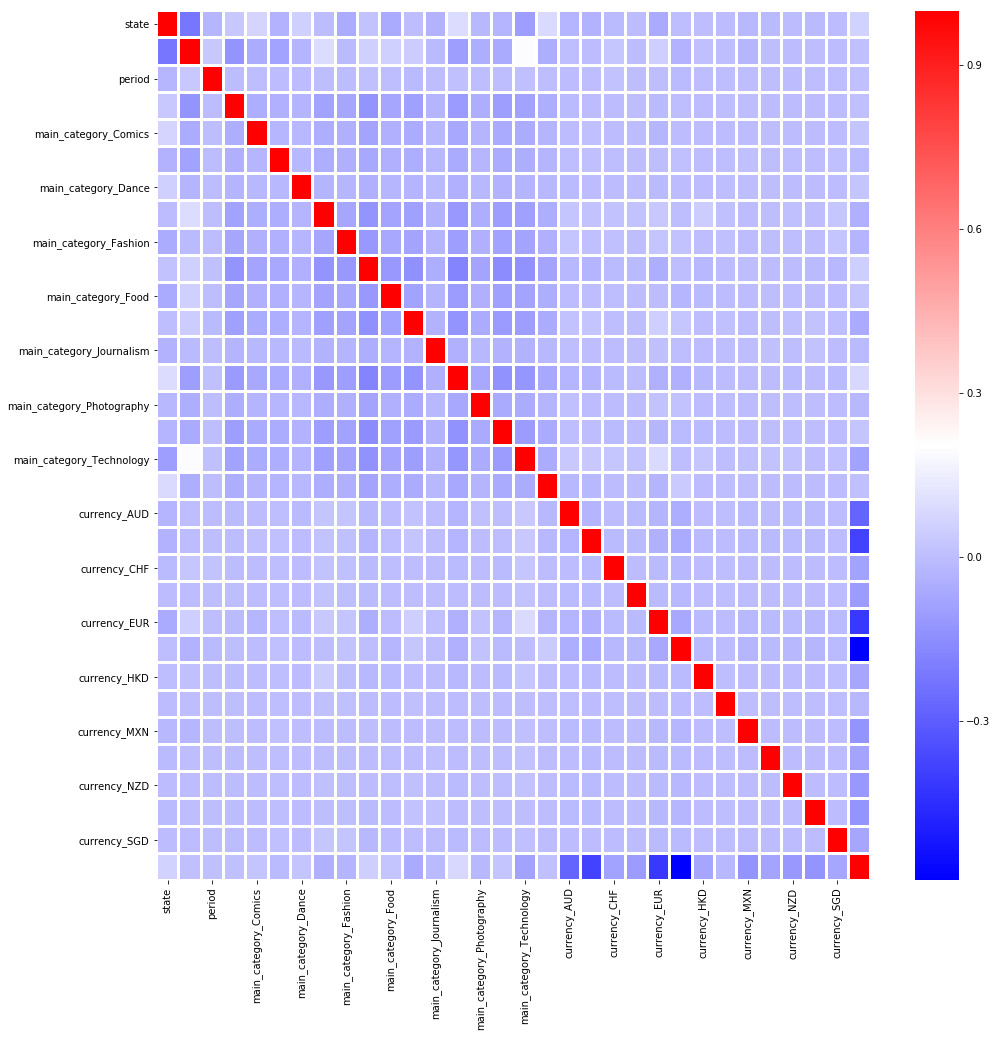

In [44]:
#ヒートマップ
# sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2) 
sns.heatmap(df.corr(),cmap='bwr',linewidths=2) 
fig=plt.gcf()
fig.set_size_inches(16,16)
plt.show()

白色化、無相関化は不要と判断

## 標準化、正規化の追加

In [137]:
#標準化
df_std = df.copy()
df_std["usd_goal_real"] =  (df_std["usd_goal_real"] - df_std["usd_goal_real"].mean()) / df_std["usd_goal_real"].std(ddof=0)
df_std["period"] =  (df_std["period"] - df_std["period"].mean()) / df_std["period"].std(ddof=0)

df_norm = df.copy()
df_norm["usd_goal_real"] = (df_norm["usd_goal_real"] - df_norm["usd_goal_real"].min()) / (df_norm["usd_goal_real"].max() - df_norm["usd_goal_real"].min())
df_norm["period"] = (df_norm["period"] - df_norm["period"].min()) / (df_norm["period"].max() - df_norm["period"].min())

df_stdnorm = df.copy()
df_stdnorm["usd_goal_real"] = (df["usd_goal_real"] - df["usd_goal_real"].min()) / (df["usd_goal_real"].max() - df_norm["usd_goal_real"].min())
df_stdnorm["period"] = (df["period"] - df["period"].min()) / (df["period"].max() - df["period"].min())

# y = df_std["state"].values
# X = df_std.drop('state', axis=1).values


### ホールドアウト法での評価

In [130]:
#評価出力用の関数定義
def evaluation(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    y_est = clf.predict(X_test)
    
#尤度、正答率、クロス集計表
    print("対数尤度=\t{}".format(log_loss(y_test,y_est)))
    print("正答率=\t\t{:.3f}%".format(accuracy_score(y_test,y_est)*100))


    precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_test, y_est)
    print("Precision =\t{:.6}%".format(precision[1]*100))
    print("Recall =\t{:.6}%".format(recall[1]*100))
    print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))

    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                            index=['正解 = failed(success以外)', '正解 = success'], 
                            columns=['予測 = failed(success以外)', '予測 = success'])
    
    return conf_mat

In [138]:
#SGDClassifierで予測

y = df["state"].values
X = df.drop('state', axis=1).values
# y = df_std["state"].values
# X = df_std.drop('state', axis=1).values
# y = df_norm["state"].values
# X = df_norm.drop('state', axis=1).values

#ホールドアウト
# X = X.reshape(-1,1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluation(X_train, X_test, y_train, y_test, clf)


対数尤度=	11.510603119353302
正答率=		66.674%
Precision =	53.1718%
Recall =	44.379%
F1値 =		48.3791%


,予測 = failed(success以外),予測 = success
正解 = failed(success以外),38667,10416
正解 = success,14823,11827


In [139]:
#SGDClassifierで予測
#標準化

# y = df["state"].values
# X = df.drop('state', axis=1).values
y = df_std["state"].values
X = df_std.drop('state', axis=1).values
# y = df_norm["state"].values
# X = df_norm.drop('state', axis=1).values


#ホールドアウト
# X = X.reshape(-1,1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluation(X_train, X_test, y_train, y_test, clf)


対数尤度=	11.345922224271614
正答率=		67.150%
Precision =	56.1528%
Recall =	30.3415%
F1値 =		39.3959%


,予測 = failed(success以外),予測 = success
正解 = failed(success以外),42769,6314
正解 = success,18564,8086


In [141]:
#SGDClassifierで予測
#正規化

# y = df["state"].values
# X = df.drop('state', axis=1).values
# y = df_std["state"].values
# X = df_std.drop('state', axis=1).values
y = df_norm["state"].values
X = df_norm.drop('state', axis=1).values


#ホールドアウト
# X = X.reshape(-1,1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
evaluation(X_train, X_test, y_train, y_test, clf)


対数尤度=	11.48957281356299
正答率=		66.734%
Precision =	55.8173%
Recall =	26.2289%
F1値 =		35.6878%


,予測 = failed(success以外),予測 = success
正解 = failed(success以外),43550,5533
正解 = success,19660,6990


正規化、標準化、どちらを使用しても正答率は向上した<br>
"period"が外れ値を含むため、標準化を採用<br>
day1時点の予測結果と比べると正答率、Precisionは15%、対数尤度は5向上している

## クロスバリデーションでの評価

In [147]:
# X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

y = df_std["state"].values
X = df_std.drop('state', axis=1).values

split_num = 1
cross_valid_log_loss = 0
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0


# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_est = clf.predict(X_test)
    
    # テストデータに対するMAEを計算
    print(split_num)
    print("対数尤度=\t{}".format(log_loss(y_test,y_est)))
    print("正答率=\t\t{:.3f}%".format(accuracy_score(y_test,y_est)*100))
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)
    print("Precision =\t{:.6}%".format(precision[1]*100))
    print("Recall =\t{:.6}%".format(recall[1]*100))
    print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))
    
    cross_valid_log_loss += log_loss(y_test,y_est)
    cross_valid_accuracy += accuracy_score(y_test,y_est)*100
    cross_valid_precision += precision[1]*100
    cross_valid_recall += recall[1]*100
    cross_valid_f1_score += f1_score[1]*100   
    split_num += 1
    
split_num -= 1
# MAEの平均値を最終的な汎化誤差値とする
print("\naverage")
print("対数尤度=\t{}".format(cross_valid_log_loss/split_num))
print("正答率=\t\t{:.3f}".format(cross_valid_accuracy/split_num))
print("Precision =\t{:.6}%".format(cross_valid_precision/split_num))
print("Recall =\t{:.6}%".format(cross_valid_recall/split_num))
print("F1値 =\t\t{:.6}%".format(cross_valid_f1_score/split_num))

1
対数尤度=	11.346379139272827
正答率=		67.149
Precision =	56.0813%
Recall =	30.6417%
F1値 =		39.6302%
2
対数尤度=	11.485612364530903
正答率=		66.746
Precision =	57.7284%
Recall =	24.409%
F1値 =		34.3106%
3
対数尤度=	11.346045719304502
正答率=		67.150
Precision =	59.9728%
Recall =	21.3763%
F1値 =		31.5184%
4
対数尤度=	11.381636495807289
正答率=		67.047
Precision =	57.5284%
Recall =	27.6512%
F1値 =		37.35%
5
対数尤度=	11.333309346104224
正答率=		67.187
Precision =	55.7756%
Recall =	33.0522%
F1値 =		41.5074%

average
対数尤度=	11.378596613003948
正答率=		67.056
Precision =	57.4173%
Recall =	27.4261%
F1値 =		36.8633%


## 正則化項の追加

In [189]:
# X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

y = df_std["state"].values
X = df_std.drop('state', axis=1).values

split_num = 1
cross_valid_log_loss = 0
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0


# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='l1', alpha = 0.01, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_est = clf.predict(X_test)
    
    # テストデータに対するMAEを計算
#     print(split_num)
#     print("対数尤度=\t{}".format(log_loss(y_test,y_est)))
#     print("正答率=\t\t{:.3f}".format(accuracy_score(y_test,y_est)*100))
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)
#     print("Precision =\t{:.6}%".format(precision[1]*100))
#     print("Recall =\t{:.6}%".format(recall[1]*100))
#     print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))
    
    cross_valid_log_loss += log_loss(y_test,y_est)
    cross_valid_accuracy += accuracy_score(y_test,y_est)*100
    cross_valid_precision += precision[1]*100
    cross_valid_recall += recall[1]*100
    cross_valid_f1_score += f1_score[1]*100   
    split_num += 1
    
split_num -= 1
# MAEの平均値を最終的な汎化誤差値とする
print("\naverage")
print("対数尤度=\t{}".format(cross_valid_log_loss/split_num))
print("正答率=\t\t{:.3f}".format(cross_valid_accuracy/split_num))
print("Precision =\t{:.6}%".format(cross_valid_precision/split_num))
print("Recall =\t{:.6}%".format(cross_valid_recall/split_num))
print("F1値 =\t\t{:.6}%".format(cross_valid_f1_score/split_num))


average
対数尤度=	12.132440277294451
正答率=		64.873
Precision =	54.6522%
Recall =	34.4053%
F1値 =		42.2272%


## グリッドサーチ/ハイパーパラメータの探索
- loss:損失関数 ["hinge", "log", "modified_huber", "squared_hinge" , "perceptron"]<br>
    まずは[log,hinge]だけで実施
- penalty:正則化項 ["l1","l2","elasticnet"]
- alpha:正則化の強度 [0.0, 1e-8, 1e-5, 1e-1,1,10]
- l1_ratio:elasticnetにおけるl1の比率 [0, 0,25, 0,5, 0.75]
- fit_intercept:切片の有無、有りにした状態で解は切片0があり得るので、Trueのみ
- max_iter:計算回数 [1000,10000,50000]ぐらい
- learning_rate:学習率の変化"optimal"を選択

In [204]:
parameters = {
                "loss":["log","hinge"],
                "penalty":["none","l1","l2","elasticnet"],
#                 "max_iter":[5000,10000,20000],
                "max_iter":[5000,10000],
                "alpha":[1e-8,1e-5, 1e-1,1,10],
                "random_state":[1234],
                "tol":[1e-3]
                }

In [205]:
y = df_std["state"].values
X = df_std.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

sgdcl = SGDClassifier(fit_intercept=True)
grid_search = GridSearchCV(sgdcl,parameters,cv=5)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_, grid_search.best_score_)

{'alpha': 1e-05, 'loss': 'log', 'max_iter': 5000, 'penalty': 'l1', 'random_state': 1234, 'tol': 0.001} 0.6709713199176042


In [207]:
clf = SGDClassifier(**grid_search.best_params_,fit_intercept=True)
clf.fit(X_test,y_test)
y_est = clf.predict(X_test)

print("対数尤度=\t{}".format(log_loss(y_test,y_est)))
print("正答率=\t\t{:.3f}%".format(accuracy_score(y_test,y_est)*100))
precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_test, y_est)
print("Precision =\t{:.6}%".format(precision[1]*100))
print("Recall =\t{:.6}%".format(recall[1]*100))
print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed(success以外)', '正解 = success'], 
                        columns=['予測 = failed(success以外)', '予測 = success'])


対数尤度=	11.592608847284074
正答率=		66.436%
Precision =	60.3359%
Recall =	13.4822%
F1値 =		22.0396%


## SVMの検討

In [2]:
#SGDClassifierで予測

y = df_std["state"].values
X = df_std.drop('state', axis=1).values

#ホールドアウト
#計算時間を考慮して1%のデータで計算
test_size = 0.99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)


parameters = {
    'kernel':['linear'],
    'C':[10,50,100],
    "gamma":[0.1,1,10]} 
model = SVC()
clf = GridSearchCV(model, parameters, cv=5,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

NameError: name 'df_std' is not defined

In [ ]:
svm = SVC(**clf.best_params_)
svm.fit(X_test,y_test)
y_est = svm.predict(X_test)

print("対数尤度=\t{}".format(log_loss(y_test,y_est)))
print("正答率=\t\t{:.3f}%".format(accuracy_score(y_test,y_est)*100))
precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_test, y_est)
print("Precision =\t{:.6}%".format(precision[1]*100))
print("Recall =\t{:.6}%".format(recall[1]*100))
print("F1値 =\t\t{:.6}%".format(f1_score[1]*100))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = failed(success以外)', '正解 = success'], 
                        columns=['予測 = failed(success以外)', '予測 = success'])


SVMは計算時間が足らず断念
正答率はDay1時点と比べ15%程改善した。